In [1]:
# upload your kaggle api token and run this cell
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
# import necessary libraries
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import cv2


In [3]:
# donwload dataset
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:20<00:00, 213MB/s]
100% 2.29G/2.29G [00:20<00:00, 122MB/s]


In [4]:
# unzip dataset
!unzip /content/chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [5]:
# prefetch data from local folders and add transformation to them for augmentation 
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rotation_range = 30,
        zoom_range=0.2,
        horizontal_flip=True)
val_Datagen = ImageDataGenerator(
        rescale = 1./255
)

train_generator = train_datagen.flow_from_directory(
        '/content/chest_xray/chest_xray/train',
        target_size=(128, 128),
        batch_size=128,
        class_mode='binary')
validation_generator = val_Datagen.flow_from_directory(
        '/content/chest_xray/chest_xray/val',
        target_size=(128, 128),
        batch_size=16,
        class_mode='binary')
test_generator = val_Datagen.flow_from_directory(
      '/content/chest_xray/chest_xray/test',
       target_size=(128, 128),
        batch_size=16,
        class_mode='binary')



Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [17]:
# load bease network which we want to do transfer learning from it and derive picture features 
base_model = tf.keras.applications.EfficientNetB2(input_shape=(128,128,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = True

In [18]:
# add classifier layers to the base network
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(128 , activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(64 , activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1 , activation='sigmoid'))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 4, 4, 1408)        7768569   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1408)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 128)               180352    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)               

In [19]:
# Complie model
base_learning_rate = 0.001
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5)]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [20]:
# train model
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    batch_size = 128)

Epoch 1/20
41/41 [==============================] - 117s 2s/step - loss: 0.2452 - accuracy: 0.8923 - val_loss: 0.7000 - val_accuracy: 0.5000
Epoch 2/20
41/41 [==============================] - 65s 2s/step - loss: 0.1318 - accuracy: 0.9534 - val_loss: 0.8329 - val_accuracy: 0.5000
Epoch 3/20
41/41 [==============================] - 65s 2s/step - loss: 0.1101 - accuracy: 0.9580 - val_loss: 1.7350 - val_accuracy: 0.5000
Epoch 4/20
41/41 [==============================] - 66s 2s/step - loss: 0.0887 - accuracy: 0.9693 - val_loss: 0.7193 - val_accuracy: 0.5000
Epoch 5/20
41/41 [==============================] - 64s 2s/step - loss: 0.0794 - accuracy: 0.9701 - val_loss: 0.7807 - val_accuracy: 0.5000
Epoch 6/20
41/41 [==============================] - 65s 2s/step - loss: 0.0748 - accuracy: 0.9716 - val_loss: 1.1007 - val_accuracy: 0.5000
Epoch 7/20
41/41 [==============================] - 65s 2s/step - loss: 0.0609 - accuracy: 0.9760 - val_loss: 0.7366 - val_accuracy: 0.5000
Epoch 8/20
41/41 [=

In [21]:
score = model.evaluate(test_generator)


39/39 [==============================] - 5s 128ms/step - loss: 0.7380 - accuracy: 0.6266


In [23]:
print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

Test Loss:  0.7379618883132935
Test Accuracy:  0.6266025900840759


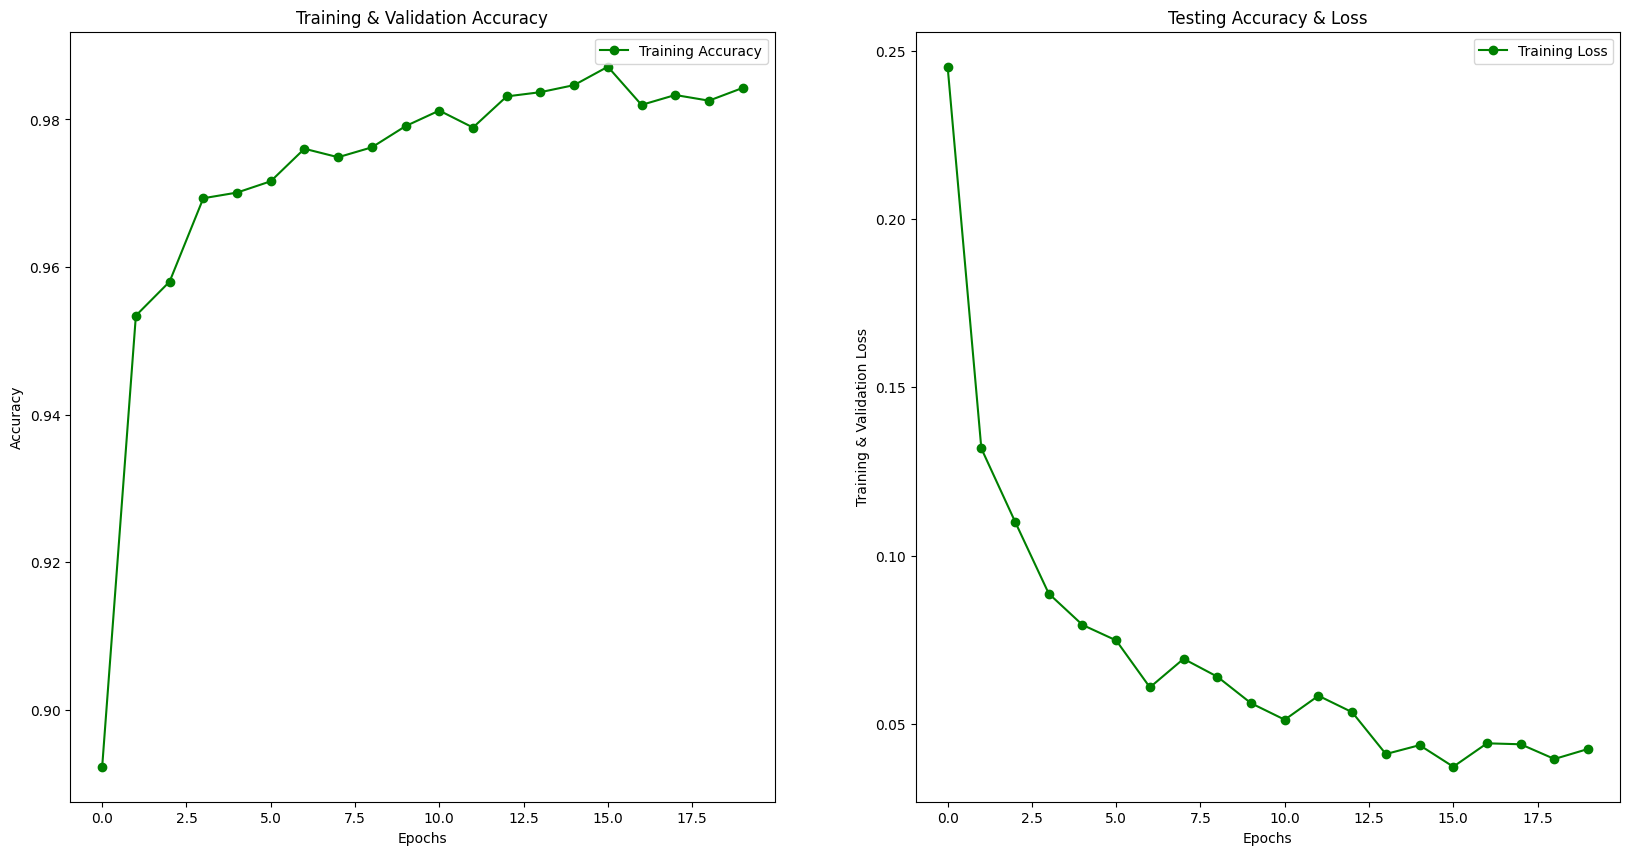

In [26]:
# plot training results 
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()